<font color='#87CEEB'>  **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU** </font>






In [15]:
import os
import pdb
import sys
import PIL
import torch
import gdown
import pickle
import tarfile
import argparse
import numpy as np
import torchvision
import pickle as pkl
import torch.nn as nn
import matplotlib as mpl
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from torch.autograd import Variable
from collections import defaultdict

##Utility

In [16]:
def get_file(fname,
             gdrive_link,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)

    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', gdrive_link)
        gdown.download(gdrive_link, fpath, quiet=False)

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir)

    return fpath


#allows accessing dictionary keys as attributes:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


##wraps a PyTorch tensor in a PyTorch Variable:
def to_var(tensor, cuda):

    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


##creates a directory if it doesn't already exist:
def create_dir_if_not_exists(directory):

    if not os.path.exists(directory):
        os.makedirs(directory)


##saves a plot of training and validation loss curves:
def save_loss_plot(train_losses, val_losses, opts):

    plt.figure()
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title('BS={}, nhid={}'.format(opts.batch_size, opts.hidden_size), fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(opts.checkpoint_path, 'loss_plot.pdf'))
    plt.close()


#plots a comparison of training and validation loss curves from all four runs,
#comparing by dataset while holding the hidden size constant
def save_loss_comparison_by_dataset(l1, l2, l3, l4, o1, o2, o3, o4, fn, s=500):

    mean_l1 = [np.mean(l1[0][i*s:(i+1)*s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i*s:(i+1)*s]) for i in range(len(l2[0]) // s)]
    mean_l3 = [np.mean(l3[0][i*s:(i+1)*s]) for i in range(len(l3[0]) // s)]
    mean_l4 = [np.mean(l4[0][i*s:(i+1)*s]) for i in range(len(l4[0]) // s)]

    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].plot(range(len(mean_l1)), mean_l1, label='ds=' + o1.data_file_name)
    ax[0][0].plot(range(len(mean_l2)), mean_l2, label='ds=' + o2.data_file_name)
    ax[0][0].title.set_text('Train Loss | Model Hidden Size = {}'.format(o1.hidden_size))

    # Validation losses are assumed to be by epoch
    ax[0][1].plot(range(len(l1[1])), l1[1], label='ds=' + o1.data_file_name)
    ax[0][1].plot(range(len(l2[1])), l2[1], label='ds=' + o2.data_file_name)
    ax[0][1].title.set_text('Val Loss | Model Hidden Size = {}'.format(o1.hidden_size))

    ax[1][0].plot(range(len(mean_l3)), mean_l3, label='ds=' + o3.data_file_name)
    ax[1][0].plot(range(len(mean_l4)), mean_l4, label='ds=' + o4.data_file_name)
    ax[1][0].title.set_text('Train Loss | Model Hidden Size = {}'.format(o3.hidden_size))

    ax[1][1].plot(range(len(l3[1])), l3[1], label='ds=' + o3.data_file_name)
    ax[1][1].plot(range(len(l4[1])), l4[1], label='ds=' + o4.data_file_name)
    ax[1][1].title.set_text('Val Loss | Model Hidden Size = {}'.format(o4.hidden_size))

    for i in range(2):
        ax[i][0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
        ax[i][0].set_ylabel("Loss", fontsize=10)
        ax[i][1].set_xlabel("Epochs", fontsize=10)
        ax[i][1].set_ylabel("Loss", fontsize=10)
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    fig.suptitle("Performance by Dataset Size", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    plt.savefig('./loss_plot_{}.pdf'.format(fn))
    plt.close()


#plots a comparison of training and validation loss curves from all four runs,
#comparing by hidden size while holding the dataset constant
def save_loss_comparison_by_hidden(l1, l2, l3, l4, o1, o2, o3, o4, fn, s=500):

    mean_l1 = [np.mean(l1[0][i*s:(i+1)*s]) for i in range(len(l1[0]) // s)]
    mean_l2 = [np.mean(l2[0][i*s:(i+1)*s]) for i in range(len(l2[0]) // s)]
    mean_l3 = [np.mean(l3[0][i*s:(i+1)*s]) for i in range(len(l3[0]) // s)]
    mean_l4 = [np.mean(l4[0][i*s:(i+1)*s]) for i in range(len(l4[0]) // s)]

    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].plot(range(len(mean_l1)), mean_l1, label='hid_size=' + str(o1.hidden_size))
    ax[0][0].plot(range(len(mean_l3)), mean_l3, label='hid_size=' + str(o3.hidden_size))
    ax[0][0].title.set_text('Train Loss | Dataset = ' + o1.data_file_name)

    # Validation losses are assumed to be by epoch
    ax[0][1].plot(range(len(l1[1])), l1[1], label='hid_size=' + str(o1.hidden_size))
    ax[0][1].plot(range(len(l3[1])), l3[1], label='hid_size=' + str(o3.hidden_size))
    ax[0][1].title.set_text('Val Loss | Dataset = ' + o1.data_file_name)

    ax[1][0].plot(range(len(mean_l2)), mean_l2, label='hid_size=' + str(o2.hidden_size))
    ax[1][0].plot(range(len(mean_l4)), mean_l4, label='hid_size=' + str(o4.hidden_size))
    ax[1][0].title.set_text('Train Loss | Dataset = ' + o3.data_file_name)

    ax[1][1].plot(range(len(l2[1])), l2[1], label='hid_size=' + str(o2.hidden_size))
    ax[1][1].plot(range(len(l4[1])), l4[1], label='hid_size=' + str(o4.hidden_size))
    ax[1][1].title.set_text('Val Loss | Dataset = ' + o4.data_file_name)

    for i in range(2):
        ax[i][0].set_xlabel("Iterations (x{})".format(s), fontsize=10)
        ax[i][0].set_ylabel("Loss", fontsize=10)
        ax[i][1].set_xlabel("Epochs", fontsize=10)
        ax[i][1].set_ylabel("Loss", fontsize=10)
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    fig.suptitle("Performance by Hidden State Size", fontsize=16)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.legend()
    plt.savefig('./loss_plot_{}.pdf'.format(fn))
    plt.close()


def checkpoint(encoder, decoder, idx_dict, opts):

    with open(os.path.join(opts.checkpoint_path, 'encoder.pt'), 'wb') as f:
        torch.save(encoder, f)

    with open(os.path.join(opts.checkpoint_path, 'decoder.pt'), 'wb') as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, 'idx_dict.pkl'), 'wb') as f:
        pkl.dump(idx_dict, f)


##Data loader

In [17]:
def read_lines(filename):

    lines = open(filename).read().strip().lower().split('\n')
    return lines


def read_pairs(filename):

    lines = read_lines(filename)
    source_words, target_words = [], []
    for line in lines:
        line = line.strip()
        if line:
            source, target = line.split()
            source_words.append(source)
            target_words.append(target)
    return source_words, target_words


def all_alpha_or_dash(s):

    return all(c.isalpha() or c == '-' for c in s)


def filter_lines(lines):

    return [line for line in lines if all_alpha_or_dash(line)]


def load_data(file_name):

    path = "./data/{}.txt".format(file_name)
    source_lines, target_lines = read_pairs(path)

    source_lines = filter_lines(source_lines)
    target_lines = filter_lines(target_lines)

    all_characters = set(''.join(source_lines)) | set(''.join(target_lines))

    char_to_index = { char: index for (index, char) in enumerate(sorted(list(all_characters))) }

    start_token = len(char_to_index)
    end_token = len(char_to_index) + 1
    char_to_index['SOS'] = start_token
    char_to_index['EOS'] = end_token

    index_to_char = { index: char for (char, index) in char_to_index.items() }

    vocab_size = len(char_to_index)

    line_pairs = list(set(zip(source_lines, target_lines)))

    idx_dict = { 'char_to_index': char_to_index,
                 'index_to_char': index_to_char,
                 'start_token': start_token,
                 'end_token': end_token }

    return line_pairs, vocab_size, idx_dict


def create_dict(pairs):

    unique_pairs = list(set(pairs))

    d = defaultdict(list)
    for (s,t) in unique_pairs:
        d[(len(s), len(t))].append((s,t))

    return d

##Training and evaluation code

In [18]:
def string_to_index_list(s, char_to_index, end_token):

    return [char_to_index[char] for char in s] + [end_token]


def translate_sentence(sentence, encoder, decoder, idx_dict, opts):

    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data(opts['data_file_name'])
    return ' '.join([translate(word, encoder, decoder, idx_dict, opts) for word in sentence.split()])


def translate(input_string, encoder, decoder, idx_dict, opts):


    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_last_hidden, encoder_last_cell = encoder(indexes)

    decoder_hidden = encoder_last_hidden
    decoder_cell = encoder_last_cell
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    for i in range(max_generated_chars):

        decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden, decoder_cell)

        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)
        ni = ni[-1]

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [index_to_char[int(item)]
                for item in generated_words.cpu().numpy().reshape(-1)])

    return gen_string


def visualize_attention(input_string, encoder, decoder, idx_dict, opts):

    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data(opts['data_file_name'])
    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)

    encoder_annotations, encoder_hidden, encoder_cell = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):

        decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden, decoder_cell)
        generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
        ni = generated_words.cpu().numpy().reshape(-1)
        ni = ni[-1]

        decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)

        if ni == end_token:
            break
        else:
            gen_string = "".join(
                [index_to_char[int(item)]
                for item in generated_words.cpu().numpy().reshape(-1)])

    if isinstance(attention_weights, tuple):

      attention_weights, self_attention_weights = attention_weights

    all_attention_weights = attention_weights.data.cpu().numpy()

    for i in range(len(all_attention_weights)):
        attention_weights_matrix = all_attention_weights[i].squeeze()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(attention_weights_matrix, cmap='bone')
        fig.colorbar(cax)

        ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
        ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.xlabel('Attention weights to the source sentence in layer {}'.format(i+1))
        plt.tight_layout()
        plt.grid('off')
        plt.show()

    return gen_string


def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in input_strings]
        target_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in target_strings]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):

            start = i * opts.batch_size
            end = start + opts.batch_size

            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)

            BS = inputs.size(0)

            encoder_annotations, encoder_hidden, encoder_cell = encoder(inputs)

            decoder_hidden = encoder_hidden
            decoder_cell = encoder_cell

            start_vector = torch.ones(BS).long().unsqueeze(1) * start_token
            decoder_input = to_var(start_vector, opts.cuda)

            loss = 0.0

            seq_len = targets.size(1)

            decoder_inputs = torch.cat([decoder_input, targets[:, 0:-1]], dim=1)

            decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden, decoder_cell)
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)

            loss = criterion(decoder_outputs_flatten, targets_flatten)

            losses.append(loss.item())

            if optimizer:

              optimizer.zero_grad()

              loss.backward()

              optimizer.step()

    return losses



def training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts):

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0

    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay

        train_loss = compute_loss(train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts)
        val_loss = compute_loss(val_dict, encoder, decoder, idx_dict, criterion, None, opts)

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter > opts.early_stopping_patience:
            print("Validation loss has not improved in {} epochs, stopping early".format(opts.early_stopping_patience))
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (train_losses, mean_val_losses)

        gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(epoch, mean_train_loss, mean_val_loss, gen_string))

        loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)

        save_loss_plot(mean_train_losses, mean_val_losses, opts)

    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    return (train_losses, mean_val_losses)


def print_data_stats(line_pairs, vocab_size, idx_dict):

    print('=' * 80)
    print('Data Stats'.center(80))
    print('-' * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print('Num unique word pairs: {}'.format(len(line_pairs)))
    print('Vocabulary: {}'.format(idx_dict['char_to_index'].keys()))
    print('Vocab size: {}'.format(vocab_size))
    print('=' * 80)


def train(opts):
    line_pairs, vocab_size, idx_dict = load_data(opts['data_file_name'])
    print_data_stats(line_pairs, vocab_size, idx_dict)

    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)


    if opts.encoder_type == "transformer":
        encoder = TransformerEncoder(vocab_size=vocab_size,
                                     hidden_size=opts.hidden_size,
                                     num_layers=opts.num_transformer_layers,
                                     opts=opts)
    else:
        raise NotImplementedError


    if opts.decoder_type == 'transformer':
        decoder = TransformerDecoder(vocab_size=vocab_size,
                                     hidden_size=opts.hidden_size,
                                     num_layers=opts.num_transformer_layers)
    else:
        raise NotImplementedError

    #### setup checkpoint path
    model_name = 'h{}-bs{}-{}-{}'.format(opts.hidden_size,
                                      opts.batch_size,
                                      opts.decoder_type,
                                      opts.data_file_name)
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        encoder.cuda()
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=opts.learning_rate)

    try:
        losses = training_loop(train_dict, val_dict, idx_dict, encoder,
                               decoder, criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, decoder, losses

    return encoder, decoder, losses


def print_opts(opts):

    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)

##Download dataset

In [19]:
data_fpath = get_file(fname='small.txt',
                            gdrive_link='https://drive.google.com/uc?id=1EMPpNu8G4rS2pBR1y5TEquQ96APUoJlR',
                            untar=False)

data_fpath = get_file(fname='large.txt',
                            gdrive_link='https://drive.google.com/uc?id=19UkiAaWV0Xs0ebnm634xL3sm9IeNYPi6',
                            untar=False)

data/small.txt
data/large.txt


#Scaled Dot Product Attention

##1: Implement Dot-Product Attention

In [20]:
class ScaledDotAttention(nn.Module):

    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):

        # ------------
        batch_size = keys.size(0)
        expanded_queries = queries.view(batch_size, -1, self.hidden_size)
        q = self.Q(expanded_queries)
        k = self.K(keys)
        v = self.V(values)
        unnormalized_attention = torch.bmm(k,q.transpose(2,1))*self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.transpose(2,1), v)

        return context, attention_weights
        # ------------


##2: Implement Causal Dot-Product Attention

<font color='#87CEEB'>این متد مشابه قبلی‌ست؛ با این تفاوت که باید محاسباتی برای برای جلوگیری از توجه به زمان‌های آینده در نظر بگیرید. می‌توانید از

'Torch.tril'

استفاده کنید
</font>






In [21]:
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7)

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):

        # ------------
        batch_size = keys.size(0)#...
        expanded_queries = queries.view(batch_size, -1, self.hidden_size)
        q = self.Q(expanded_queries)#...
        k = self.K(keys)#...
        v = self.V(values)#...
        unnormalized_attention = torch.bmm(k,q.transpose(2,1))*self.scaling_factor#...
        mask=torch.tril(torch.full((batch_size,keys.size(1),expanded_queries.size(1)),self.neg_inf),diagonal=-1)
        attention_weights = self.softmax(unnormalized_attention+mask.cuda())#...
        context = torch.bmm(attention_weights.transpose(2,1), v)#...
        return context, attention_weights
        # ------------



##3: Transformer Encoder

In [22]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, opts):
        super(TransformerEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.self_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size,
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs):

        batch_size, seq_len = inputs.size()

        encoded = self.embedding(inputs)

        encoded = encoded + self.positional_encodings[:seq_len]

        annotations = encoded
        for i in range(self.num_layers):
            new_annotations, self_attention_weights = self.self_attentions[i](annotations, annotations, annotations)
            residual_annotations = annotations + new_annotations
            new_annotations = self.attention_mlps[i](residual_annotations)
            annotations = residual_annotations + new_annotations


        return annotations, None, None

    def create_positional_encodings(self, max_seq_len=1000):

        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size//2)[None, ...]
        exponents = (2*dim_indices).float()/(self.hidden_size)
        trig_args = pos_indices / (10000**exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        if self.opts.cuda:
            pos_encodings = pos_encodings.cuda()

        return pos_encodings

##4: Transformer Decoder

In [23]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.num_layers = num_layers

        self.self_attentions = nn.ModuleList([CausalScaledDotAttention(
                                    hidden_size=hidden_size,
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size,
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])
        self.out = nn.Linear(hidden_size, vocab_size)

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs, annotations, hidden_init, cell_init):

        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)

        embed = embed + self.positional_encodings[:seq_len]

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
            new_contexts, self_attention_weights = self.self_attentions[i](contexts, contexts, contexts)
            residual_contexts = contexts + new_contexts
            new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts, annotations, annotations)
            residual_contexts = residual_contexts + new_contexts
            new_contexts = self.attention_mlps[i](residual_contexts)
            contexts = residual_contexts + new_contexts

            encoder_attention_weights_list.append(encoder_attention_weights)
            self_attention_weights_list.append(self_attention_weights)

        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)

        return output, (encoder_attention_weights, self_attention_weights)

    def create_positional_encodings(self, max_seq_len=1000):

        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size//2)[None, ...]
        exponents = (2*dim_indices).float()/(self.hidden_size)
        trig_args = pos_indices / (10000**exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        pos_encodings = pos_encodings.cuda()

        return pos_encodings

##5: Training and analysis

Run the Transformer model using hidden size 32 versus 64, and using the small versus large dataset (in total, 4 runs)

In [24]:
TEST_SENTENCE = 'the air conditioning is working'

trans32_args_s = AttrDict()
args_dict = {
              'data_file_name': 'small',
              'cuda':True,
              'nepochs':100,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 100,
              'lr_decay':0.99,
              'batch_size': 64,
              'hidden_size': 32,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans32_args_s.update(args_dict)
print_opts(trans32_args_s)

trans32_encoder_s, trans32_decoder_s, trans32_losses_s = train(trans32_args_s)

translated = translate_sentence(TEST_SENTENCE, trans32_encoder_s, trans32_decoder_s, None, trans32_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: small                                  
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 32                                     
                           encoder_type: transformer                            
                           d

In [25]:
TEST_SENTENCE = 'the air conditioning is working'

trans32_args_l = AttrDict()
args_dict = {
              'data_file_name': 'large',
              'cuda':True,
              'nepochs':100,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 10,
              'lr_decay':0.99,
              'batch_size': 512,
              'hidden_size': 32,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans32_args_l.update(args_dict)
print_opts(trans32_args_l)

trans32_encoder_l, trans32_decoder_l, trans32_losses_l = train(trans32_args_l)

translated = translate_sentence(TEST_SENTENCE, trans32_encoder_l, trans32_decoder_l, None, trans32_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: large                                  
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 10                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 32                                     
                           encoder_type: transformer                            
                           d

In [26]:
TEST_SENTENCE = 'the air conditioning is working'

trans64_args_s = AttrDict()
args_dict = {
              'data_file_name': 'small',
              'cuda':True,
              'nepochs':50,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 20,
              'lr_decay':0.99,
              'batch_size': 64,
              'hidden_size': 64,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans64_args_s.update(args_dict)
print_opts(trans64_args_s)

trans64_encoder_s, trans64_decoder_s, trans64_losses_s = train(trans64_args_s)

translated = translate_sentence(TEST_SENTENCE, trans64_encoder_s, trans64_decoder_s, None, trans64_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: small                                  
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 64                                     
                           encoder_type: transformer                            
                           d

In [27]:
TEST_SENTENCE = 'the air conditioning is working'

trans64_args_l = AttrDict()
args_dict = {
              'data_file_name': 'large',
              'cuda':True,
              'nepochs':50,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 20,
              'lr_decay':0.99,
              'batch_size': 512,
              'hidden_size': 64,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans64_args_l.update(args_dict)
print_opts(trans64_args_l)

trans64_encoder_l, trans64_decoder_l, trans64_losses_l = train(trans64_args_l)

translated = translate_sentence(TEST_SENTENCE, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: large                                  
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 64                                     
                           encoder_type: transformer                            
                           d

In [28]:
save_loss_comparison_by_dataset(trans32_losses_s, trans32_losses_l, trans64_losses_s, trans64_losses_l, trans32_args_s, trans32_args_l, trans64_args_s, trans64_args_l, 'trans_by_dataset')
save_loss_comparison_by_hidden(trans32_losses_s, trans32_losses_l, trans64_losses_s, trans64_losses_l, trans32_args_s, trans32_args_l, trans64_args_s, trans64_args_l, 'trans_by_hidden')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#Attention Visualizations

<ipython-input-18-a744edffd381>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
<ipython-input-18-a744edffd381>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))


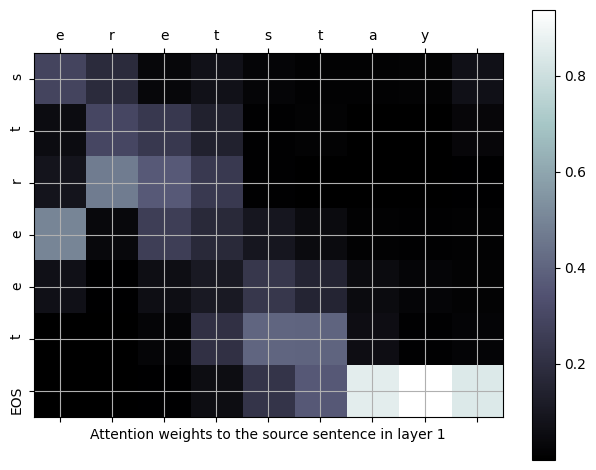

<ipython-input-18-a744edffd381>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
<ipython-input-18-a744edffd381>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))


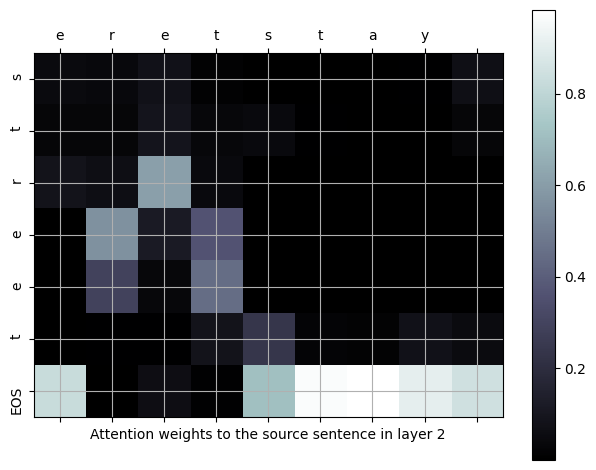

<ipython-input-18-a744edffd381>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
<ipython-input-18-a744edffd381>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))


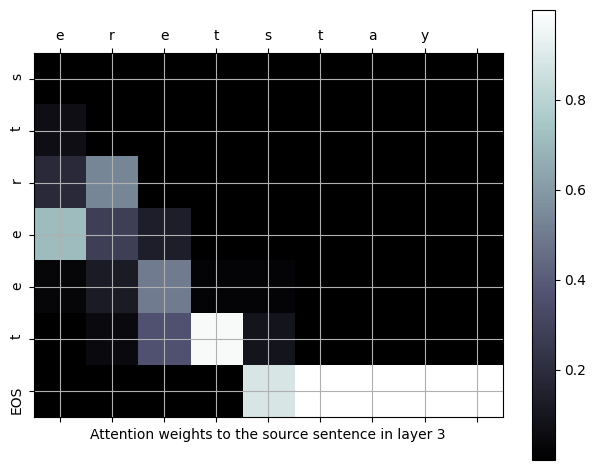

'eretstay'

In [32]:
TEST_WORD_ATTN = 'street'
visualize_attention(TEST_WORD_ATTN, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l)


# Modified TransformerDecoder


In [45]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.num_layers = num_layers

        self.self_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size,
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size,
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])
        self.out = nn.Linear(hidden_size, vocab_size)

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs, annotations, hidden_init, cell_init):

        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)

        embed = embed + self.positional_encodings[:seq_len]

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
            new_contexts, self_attention_weights = self.self_attentions[i](contexts, contexts, contexts)
            residual_contexts = contexts + new_contexts
            new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts, annotations, annotations)
            residual_contexts = residual_contexts + new_contexts
            new_contexts = self.attention_mlps[i](residual_contexts)
            contexts = residual_contexts + new_contexts

            encoder_attention_weights_list.append(encoder_attention_weights)
            self_attention_weights_list.append(self_attention_weights)

        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)

        return output, (encoder_attention_weights, self_attention_weights)

    def create_positional_encodings(self, max_seq_len=1000):

        pos_indices = torch.arange(max_seq_len)[..., None]
        dim_indices = torch.arange(self.hidden_size//2)[None, ...]
        exponents = (2*dim_indices).float()/(self.hidden_size)
        trig_args = pos_indices / (10000**exponents)
        sin_terms = torch.sin(trig_args)
        cos_terms = torch.cos(trig_args)

        pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
        pos_encodings[:, 0::2] = sin_terms
        pos_encodings[:, 1::2] = cos_terms

        pos_encodings = pos_encodings.cuda()

        return pos_encodings

In [46]:
TEST_SENTENCE = 'the air conditioning is working'

trans32_args_s = AttrDict()
args_dict = {
              'data_file_name': 'small',
              'cuda':True,
              'nepochs':100,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 100,
              'lr_decay':0.99,
              'batch_size': 64,
              'hidden_size': 32,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans32_args_s.update(args_dict)
print_opts(trans32_args_s)

trans32_encoder_s, trans32_decoder_s, trans32_losses_s = train(trans32_args_s)

translated = translate_sentence(TEST_SENTENCE, trans32_encoder_s, trans32_decoder_s, None, trans32_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: small                                  
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 100                                    
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 32                                     
                           encoder_type: transformer                            
                           d

In [47]:
TEST_SENTENCE = 'the air conditioning is working'

trans32_args_l = AttrDict()
args_dict = {
              'data_file_name': 'large',
              'cuda':True,
              'nepochs':100,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 10,
              'lr_decay':0.99,
              'batch_size': 512,
              'hidden_size': 32,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans32_args_l.update(args_dict)
print_opts(trans32_args_l)

trans32_encoder_l, trans32_decoder_l, trans32_losses_l = train(trans32_args_l)

translated = translate_sentence(TEST_SENTENCE, trans32_encoder_l, trans32_decoder_l, None, trans32_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: large                                  
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 10                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 32                                     
                           encoder_type: transformer                            
                           d

In [48]:
TEST_SENTENCE = 'the air conditioning is working'

trans64_args_s = AttrDict()
args_dict = {
              'data_file_name': 'small',
              'cuda':True,
              'nepochs':50,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 20,
              'lr_decay':0.99,
              'batch_size': 64,
              'hidden_size': 64,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans64_args_s.update(args_dict)
print_opts(trans64_args_s)

trans64_encoder_s, trans64_decoder_s, trans64_losses_s = train(trans64_args_s)

translated = translate_sentence(TEST_SENTENCE, trans64_encoder_s, trans64_decoder_s, None, trans64_args_s)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: small                                  
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 64                                     
                           encoder_type: transformer                            
                           d

In [49]:
TEST_SENTENCE = 'the air conditioning is working'

trans64_args_l = AttrDict()
args_dict = {
              'data_file_name': 'large',
              'cuda':True,
              'nepochs':50,
              'checkpoint_dir':"checkpoints",
              'learning_rate':5e-4,
              'early_stopping_patience': 20,
              'lr_decay':0.99,
              'batch_size': 512,
              'hidden_size': 64,
              'encoder_type': 'transformer',
              'decoder_type': 'transformer',
              'num_transformer_layers': 3,
}
trans64_args_l.update(args_dict)
print_opts(trans64_args_l)

trans64_encoder_l, trans64_decoder_l, trans64_losses_l = train(trans64_args_l)

translated = translate_sentence(TEST_SENTENCE, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                         data_file_name: large                                  
                                   cuda: 1                                      
                                nepochs: 50                                     
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.0005                                 
                early_stopping_patience: 20                                     
                               lr_decay: 0.99                                   
                             batch_size: 512                                    
                            hidden_size: 64                                     
                           encoder_type: transformer                            
                           d

In [50]:
save_loss_comparison_by_dataset(trans32_losses_s, trans32_losses_l, trans64_losses_s, trans64_losses_l, trans32_args_s, trans32_args_l, trans64_args_s, trans64_args_l, 'trans_by_dataset')
save_loss_comparison_by_hidden(trans32_losses_s, trans32_losses_l, trans64_losses_s, trans64_losses_l, trans32_args_s, trans32_args_l, trans64_args_s, trans64_args_l, 'trans_by_hidden')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<ipython-input-18-a744edffd381>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
<ipython-input-18-a744edffd381>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))


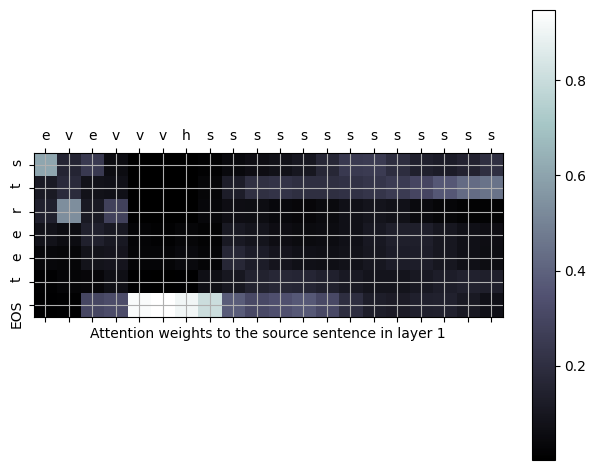

<ipython-input-18-a744edffd381>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
<ipython-input-18-a744edffd381>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))


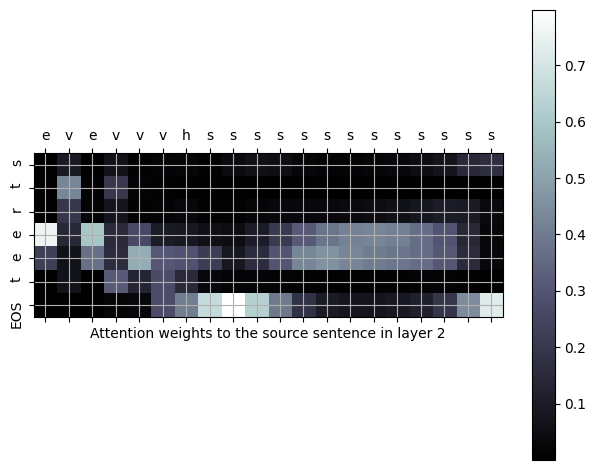

<ipython-input-18-a744edffd381>:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
<ipython-input-18-a744edffd381>:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))


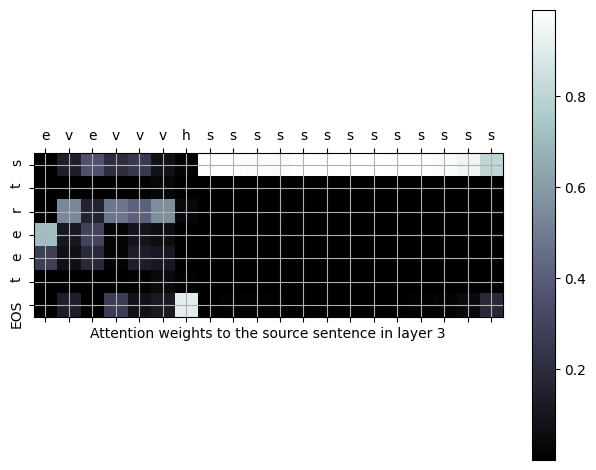

'evevvvhsssssssssssss'

In [51]:
TEST_WORD_ATTN = 'street'
visualize_attention(TEST_WORD_ATTN, trans64_encoder_l, trans64_decoder_l, None, trans64_args_l)